<a href="https://colab.research.google.com/github/Siji-Jaimal/Siji-Jaimal/blob/main/Potato_leaf_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from zipfile import ZipFile
file_name = "PlantVillage.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('done')


done


In [6]:
import numpy as np # for linear algebra
import pandas as pd # data preprocessing

import tensorflow as tf # deep learning
from tensorflow.keras import layers, models # working on layers
import matplotlib.pyplot as plt # data visualization

In [7]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [8]:
df = tf.keras.preprocessing.image_dataset_from_directory("PlantVillage",shuffle=True,image_size= (IMAGE_SIZE,IMAGE_SIZE),
                                                        batch_size= BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [9]:
class_names = df.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [10]:
len(df)

68

In [11]:
68*32

2176

In [12]:
print(df)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


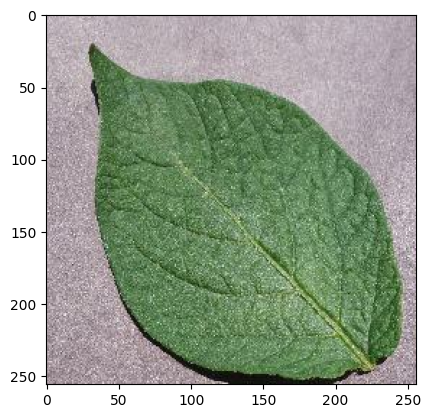

In [13]:
for image_batch, label_batch in df.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))

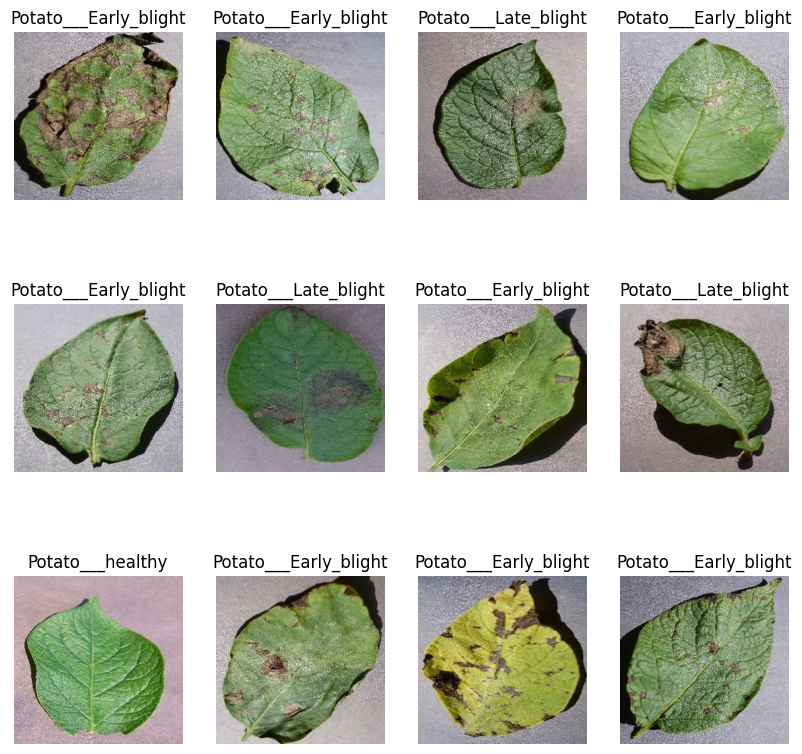

In [14]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in df.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [15]:
CHANNELS = 3
EPOCHS = 50

In [16]:
train_size = 0.8
len(df) * train_size

54.400000000000006

In [17]:
val_n_test = len(df) - (len(df) * train_size)
val_n_test

13.599999999999994

In [18]:
def split_datasets(pc,train_split = 0.8,val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    if shuffle:
        pc = pc.shuffle(shuffle_size,seed = 10)

    pc_size = len(pc)
    train_size = int(train_split*pc_size)
    val_size = int(val_split*pc_size)

    train_pc = pc.take(train_size)
    val_pc = pc.skip(train_size).take(val_size)
    test_pc = pc.skip(train_size).skip(val_size)
    return train_pc, val_pc, test_pc


In [19]:
train_data, val_data, test_data = split_datasets(df)
print("Size of Data is :{0} \nBatch Size of Training Data is :{1} \nBatch Size of Validation Data :{2} \nBatch Size of Test Data :{3}"
      .format(len(df), len(train_data), len(val_data), len(test_data)))

Size of Data is :68 
Batch Size of Training Data is :54 
Batch Size of Validation Data :6 
Batch Size of Test Data :8


In [20]:
train_pc = train_data.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_pc = val_data.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
test_pc = test_data.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
rescale_n_resize = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode ='horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(factor=0.5)
])

In [24]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    rescale_n_resize,
    data_augmentation,
    layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(64, activation = 'softmax')

])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 16)        448       
                                                                 
 max_pooling2d_12 (MaxPooli  (32, 127, 127, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        9280      
                                                                 
 max_pooling2d_13 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

In [25]:
model.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

In [27]:
history = model.fit(train_data, epochs = EPOCHS, batch_size=BATCH_SIZE, validation_data=val_data, verbose=1)

Epoch 1/50
54/54 [==============================] - 229s 4s/step - loss: 0.1366 - accuracy: 0.9473 - val_loss: 0.2073 - val_accuracy: 0.9115
Epoch 2/50
54/54 [==============================] - 221s 4s/step - loss: 0.1258 - accuracy: 0.9572 - val_loss: 0.1667 - val_accuracy: 0.9323
Epoch 3/50
54/54 [==============================] - 218s 4s/step - loss: 0.0990 - accuracy: 0.9654 - val_loss: 0.2715 - val_accuracy: 0.9010
Epoch 4/50
54/54 [==============================] - 220s 4s/step - loss: 0.0960 - accuracy: 0.9642 - val_loss: 0.1389 - val_accuracy: 0.9375
Epoch 5/50
54/54 [==============================] - 223s 4s/step - loss: 0.0825 - accuracy: 0.9676 - val_loss: 0.1498 - val_accuracy: 0.9479
Epoch 6/50
54/54 [==============================] - 219s 4s/step - loss: 0.0941 - accuracy: 0.9636 - val_loss: 0.2946 - val_accuracy: 0.8906
Epoch 7/50
54/54 [==============================] - 219s 4s/step - loss: 0.1082 - accuracy: 0.9641 - val_loss: 0.1504 - val_accuracy: 0.9375
Epoch 8/50
54

In [28]:
scores = model.evaluate(train_data)
scores

54/54 [==============================] - 65s 1s/step - loss: 0.0929 - accuracy: 0.9683


[0.09285527467727661, 0.9683098793029785]

In [29]:
history.params, history.history.keys()

({'verbose': 1, 'epochs': 50, 'steps': 54},
 dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy']))

In [30]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

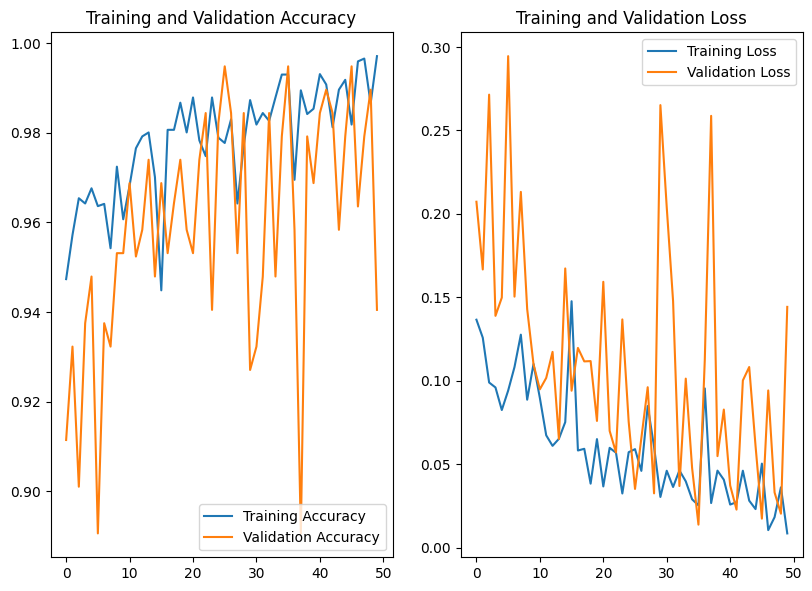

In [31]:
plt.figure(figsize = (15,15))

# Accuracy Table
plt.subplot(2,3,1)
plt.plot(range(EPOCHS),train_acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss Table
plt.subplot(2,3,2)
plt.plot(range(EPOCHS),train_loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

1/1 [==============================] - 1s 1s/step


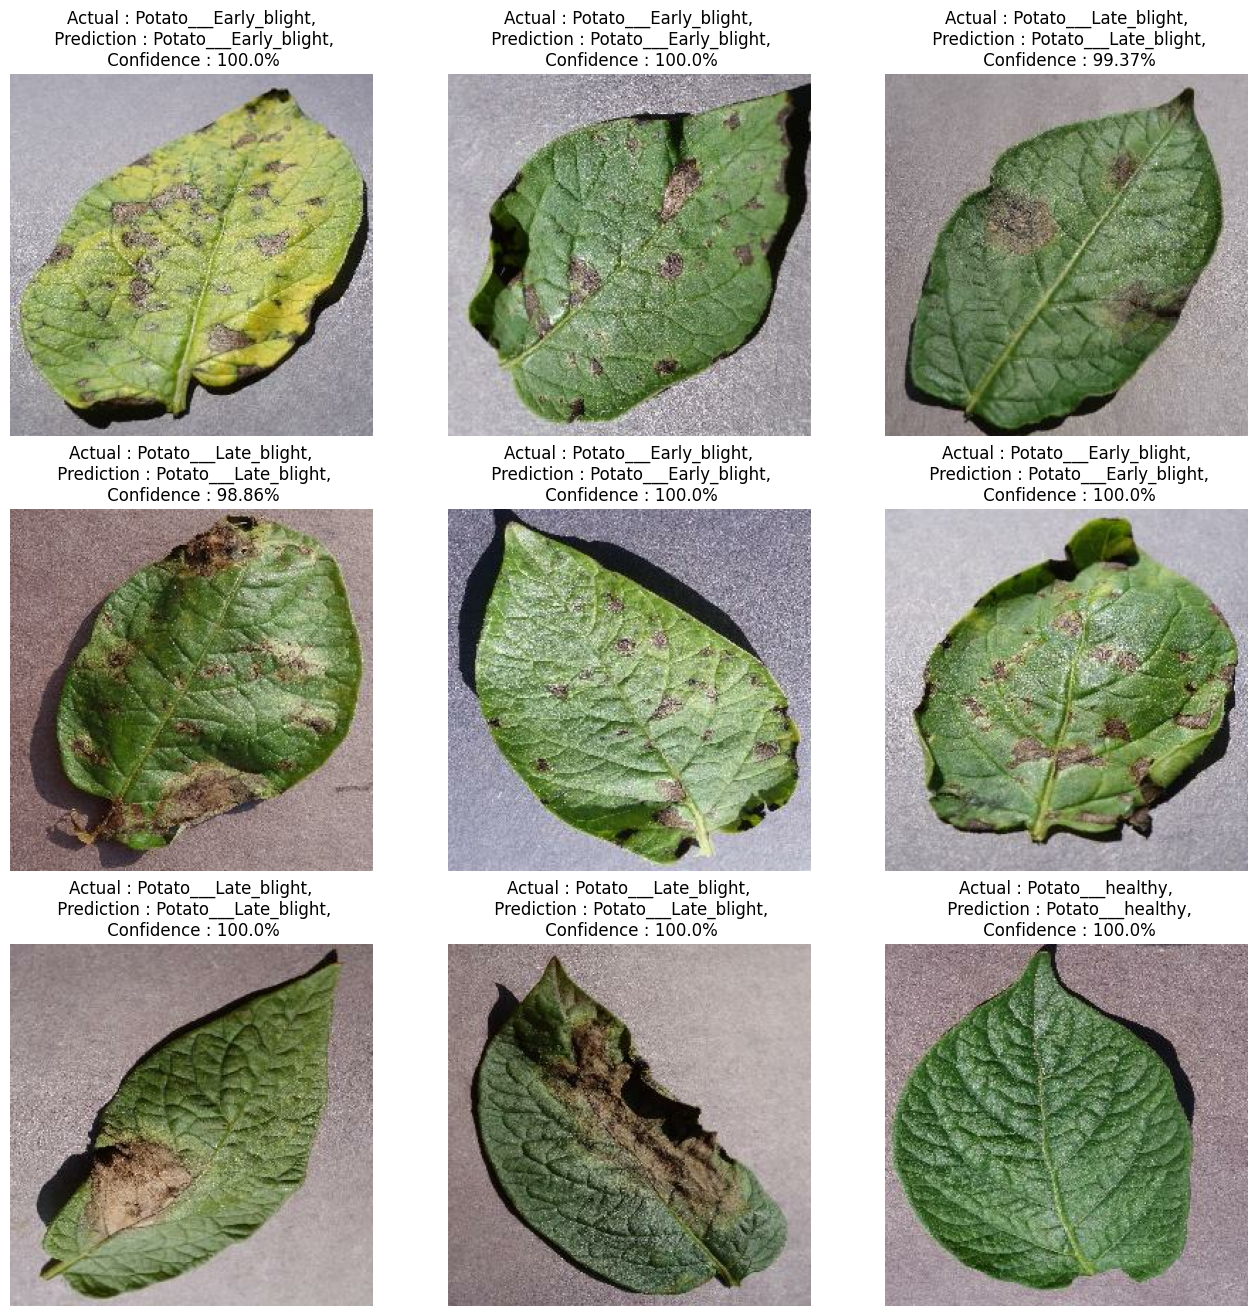

In [32]:
plt.figure(figsize = (16,16))
for batch_image, batch_label in test_pc.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        image = batch_image[i].numpy().astype('uint8')
        label = class_names[batch_label[i]]

        plt.imshow(image)

        batch_prediction = model.predict(batch_image)
        predicted_class = class_names[np.argmax(batch_prediction[i])]
        confidence = round(np.max(batch_prediction[i]) * 100, 2)

        plt.title(f'Actual : {label},\n Prediction : {predicted_class},\n Confidence : {confidence}%')

        plt.axis('off')

In [34]:
unk_lf = tf.keras.preprocessing.image_dataset_from_directory("PlantVillage",
                                                             image_size=(IMAGE_SIZE,IMAGE_SIZE))

Found 2152 files belonging to 3 classes.


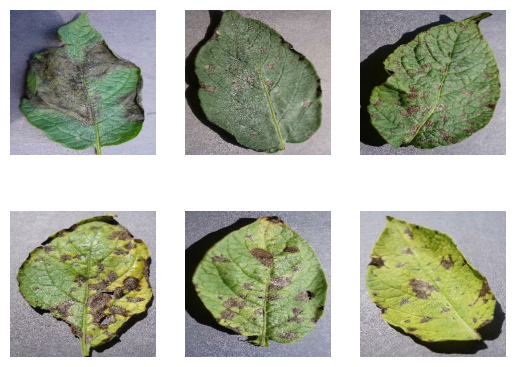

In [35]:
for image_batch, label_batch in unk_lf.take(1):
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")

1/1 [==============================] - 1s 1s/step


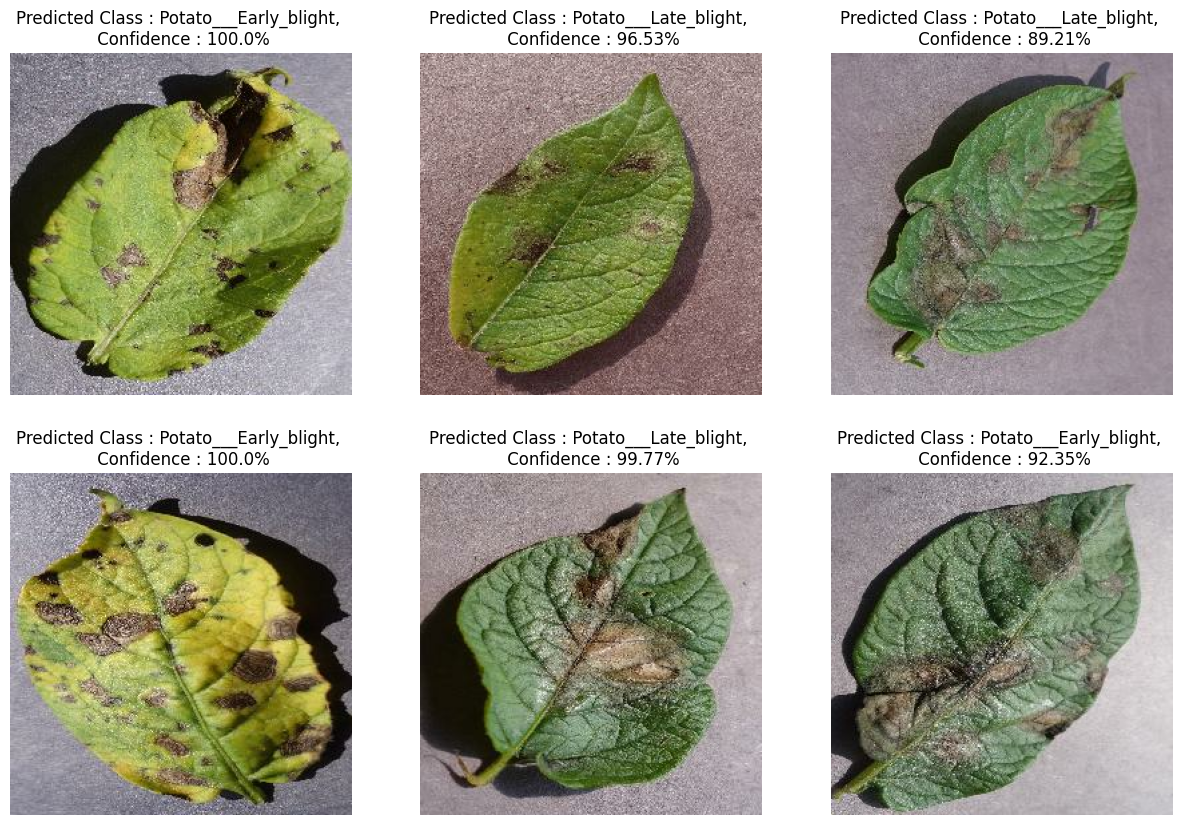

In [36]:
plt.figure(figsize = (15,10))
for image_batch, label_batch in unk_lf.take(1):
    for i in range(6):
        ax = plt.subplot(2,3,i+1)
        image = image_batch[i].numpy().astype("uint8")
        label = class_names[label_batch[i]]

        plt.imshow(image)


        unk_lf_pred = model.predict(image_batch)
        pred_class = class_names[np.argmax(unk_lf_pred[i])]
        confidence = round(np.max(unk_lf_pred[i])*100, 2)

        plt.title(f'Predicted Class : {pred_class}, \n Confidence : {confidence}%')

        plt.axis("off")